# 객체 탐지 성능 지표: mAP50 vs mAP50-95 이해하기

객체 탐지 모델의 성능은 mAP(mean Average Precision)라는 종합적인 지표로 평가.
이 노트북은 mAP 계산의 기반이 되는 IoU, AP 개념을 먼저 알아보고, 가장 널리 쓰이는 mAP50과 mAP50-95의 차이를 코드로 직접 확인하는 것을 목표로 함.

## 1. 기본 설정 및 유틸리티 함수

시각화 및 계산에 필요한 라이브러리를 임포트하고, 경계 상자를 그리는 유틸리티 함수를 정의.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_boxes(box_a, box_b, title):
    """두 개의 경계 상자와 IoU를 시각화하는 함수"""
    fig, ax = plt.subplots(1)
    ax.set_aspect('equal')

    # box_a (정답 상자) 그리기
    rect_a = patches.Rectangle((box_a[0], box_a[1]), box_a[2]-box_a[0], box_a[3]-box_a[1], linewidth=2, edgecolor='r', facecolor='none', label='Ground Truth')
    ax.add_patch(rect_a)

    # box_b (예측 상자) 그리기
    rect_b = patches.Rectangle((box_b[0], box_b[1]), box_b[2]-box_b[0], box_b[3]-box_b[1], linewidth=2, edgecolor='b', facecolor='none', label='Prediction')
    ax.add_patch(rect_b)
    
    iou = calculate_iou(box_a, box_b)
    plt.title(f'{title}\nIoU: {iou:.4f}')
    plt.xlim(0, 12)
    plt.ylim(0, 12)
    plt.legend()
    plt.show()

## 2. IoU (Intersection over Union) 계산

IoU는 모델이 예측한 경계 상자(Bounding Box)와 실제 정답 상자가 얼마나 겹치는지를 나타내는 지표. 모델 예측의 '성공' 여부를 판단하는 첫 단계.

- **계산식**: (교집합 영역 넓이) / (합집합 영역 넓이)

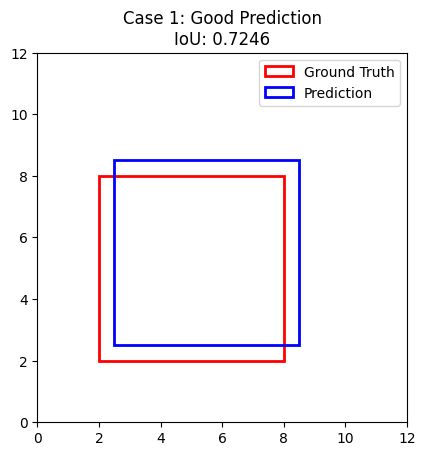

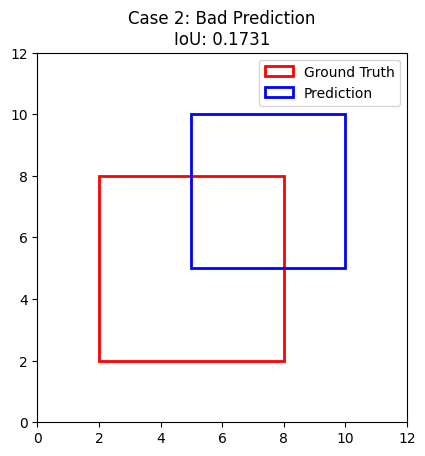

In [2]:
def calculate_iou(box_a, box_b):
    """두 경계 상자(x1, y1, x2, y2)의 IoU를 계산하는 함수"""
    # 교집합(intersection) 영역 좌표 계산
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])

    # 교집합 넓이 계산
    intersection_area = max(0, x_b - x_a) * max(0, y_b - y_a)

    # 각 상자의 넓이 계산
    box_a_area = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    box_b_area = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])

    # 합집합(union) 넓이 계산
    union_area = box_a_area + box_b_area - intersection_area

    # IoU 계산
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

# 예시 데이터: [x1, y1, x2, y2]
ground_truth_box = [2, 2, 8, 8]  # 정답 상자

# Case 1: 예측이 매우 정확한 경우
good_prediction_box = [2.5, 2.5, 8.5, 8.5]
plot_boxes(ground_truth_box, good_prediction_box, 'Case 1: Good Prediction')

# Case 2: 예측이 부정확한 경우
bad_prediction_box = [5, 5, 10, 10]
plot_boxes(ground_truth_box, bad_prediction_box, 'Case 2: Bad Prediction')

## 3. AP (Average Precision) 계산
AP는 한 클래스에 대한 모델의 종합 성능. 정밀도(Precision)와 재현율(Recall)을 모두 고려하여 계산.

1.  **IoU 임계값**을 기준으로 예측들을 **TP(True Positive)** 또는 **FP(False Positive)**로 분류.
2.  예측들을 **신뢰도(Confidence Score)** 순으로 정렬.
3.  정렬된 순서대로 정밀도-재현율 곡선을 그려 아래 면적(AP)을 계산.

In [3]:
def calculate_ap(gts, preds, iou_threshold):
    """단일 클래스에 대한 AP를 계산하는 함수"""
    # 예측을 신뢰도 점수 기준으로 내림차순 정렬
    preds = sorted(preds, key=lambda x: x['confidence'], reverse=True)
    
    tps = np.zeros(len(preds))
    fps = np.zeros(len(preds))
    total_true_positives = len(gts)
    
    # 각 예측에 대해 TP/FP 판정
    detected_gts = [] # 이미 매칭된 정답 상자
    for i, pred in enumerate(preds):
        best_iou = 0
        best_gt_idx = -1
        for j, gt in enumerate(gts):
            iou = calculate_iou(pred['box'], gt['box'])
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = j
        
        if best_iou >= iou_threshold and best_gt_idx not in detected_gts:
            tps[i] = 1
            detected_gts.append(best_gt_idx)
        else:
            fps[i] = 1
            
    # 정밀도 및 재현율 계산
    cumulative_tps = np.cumsum(tps)
    cumulative_fps = np.cumsum(fps)
    
    recalls = cumulative_tps / total_true_positives if total_true_positives > 0 else 0
    precisions = cumulative_tps / (cumulative_tps + cumulative_fps)
    
    # AP 계산 (11-point interpolation)
    ap = 0
    for t in np.arange(0., 1.1, 0.1):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 11
        
    return ap, recalls, precisions

# 예시 데이터 (단일 클래스: 'cat')
gts_cat = [{'box': [1, 2, 4, 5]}, {'box': [6, 6, 9, 9]}]
preds_cat = [
    {'box': [1.1, 2.1, 4.2, 5.2], 'confidence': 0.95}, # IoU 높음, TP 예상
    {'box': [5, 5, 8, 8], 'confidence': 0.88},       # IoU 낮음, FP 예상
    {'box': [6.1, 6.2, 9.1, 9.2], 'confidence': 0.98}  # IoU 높음, TP 예상
]

# IoU 임계값 0.5에서 AP 계산
ap_50, recalls, precisions = calculate_ap(gts_cat, preds_cat, iou_threshold=0.5)
print(f"IoU Threshold: 0.5")
print(f"AP: {ap_50:.4f}")

# IoU 임계값 0.8에서 AP 계산 (더 엄격한 기준)
ap_80, _, _ = calculate_ap(gts_cat, preds_cat, iou_threshold=0.8)
print(f"\nIoU Threshold: 0.8")
print(f"AP: {ap_80:.4f}")

IoU Threshold: 0.5
AP: 1.0000

IoU Threshold: 0.8
AP: 1.0000


## 4. mAP50 vs mAP50-95 계산 및 비교

이제 핵심 개념인 mAP50과 mAP50-95를 계산. 둘의 차이는 **어떤 IoU 임계값을 사용해 AP를 계산하고 평균 내는가**에 있음.

- **mAP50**: IoU 임계값을 **0.5 하나로 고정**하고 mAP 계산. 위치가 다소 부정확해도 너그럽게 평가.
- **mAP50-95**: IoU 임계값을 **0.5부터 0.95까지 0.05씩** 바꿔가며 각각 mAP를 계산한 후, 그 결과들을 다시 **평균**낸 값. 위치 정확도까지 엄격하게 평가.

In [4]:
# 다중 클래스를 가정한 예시 데이터
# gts: {'class_name': [gt_boxes, ...]}
# preds: {'class_name': [pred_boxes, ...]}
all_gts = {
    'cat': [{'box': [1, 2, 4, 5]}, {'box': [6, 6, 9, 9]}],
    'dog': [{'box': [3, 3, 6, 7]}]
}

all_preds = {
    'cat': [
        {'box': [1.1, 2.1, 4.2, 5.2], 'confidence': 0.95}, # cat GT 1과 IoU 높음
        {'box': [5, 5, 8, 8], 'confidence': 0.88},       # 모든 cat GT와 IoU 낮음
        {'box': [6.1, 6.2, 9.1, 9.2], 'confidence': 0.98}  # cat GT 2와 IoU 높음
    ],
    'dog': [
        {'box': [3.5, 3.5, 6.5, 7.5], 'confidence': 0.92} # dog GT와 IoU 중간 정도
    ]
}

classes = all_gts.keys()

# --- mAP50 계산 ---
print("--- Calculating mAP50 ---")
ap_per_class_50 = []
for cls in classes:
    ap, _, _ = calculate_ap(all_gts[cls], all_preds.get(cls, []), iou_threshold=0.5)
    ap_per_class_50.append(ap)
    print(f"  AP@.50 for class '{cls}': {ap:.4f}")

mAP50 = np.mean(ap_per_class_50)
print(f"\nResult -> mAP50: {mAP50:.4f}\n")

# --- mAP50-95 계산 ---
print("--- Calculating mAP50-95 ---")
iou_thresholds = np.arange(0.5, 1.0, 0.05)
mAPs = []

for iou_t in iou_thresholds:
    ap_per_class = []
    for cls in classes:
        ap, _, _ = calculate_ap(all_gts[cls], all_preds.get(cls, []), iou_threshold=iou_t)
        ap_per_class.append(ap)
    
    mAP_at_t = np.mean(ap_per_class)
    mAPs.append(mAP_at_t)
    print(f"  mAP @ IoU={iou_t:.2f}: {mAP_at_t:.4f}")

mAP50_95 = np.mean(mAPs)
print(f"\nResult -> mAP50-95: {mAP50_95:.4f}")

--- Calculating mAP50 ---
  AP@.50 for class 'cat': 1.0000
  AP@.50 for class 'dog': 1.0000

Result -> mAP50: 1.0000

--- Calculating mAP50-95 ---
  mAP @ IoU=0.50: 1.0000
  mAP @ IoU=0.55: 1.0000
  mAP @ IoU=0.60: 0.5000
  mAP @ IoU=0.65: 0.5000
  mAP @ IoU=0.70: 0.5000
  mAP @ IoU=0.75: 0.5000
  mAP @ IoU=0.80: 0.5000
  mAP @ IoU=0.85: 0.0000
  mAP @ IoU=0.90: 0.0000
  mAP @ IoU=0.95: 0.0000

Result -> mAP50-95: 0.4500


### 결과 분석

위 코드 실행 결과를 보면, IoU 임계값이 높아질수록(기준이 엄격해질수록) mAP 점수가 하락하는 경향을 보임. 

- `dog` 클래스의 예측은 IoU가 0.5 근처였기 때문에, mAP50 계산 시에는 높은 AP를 기록했지만, 임계값이 0.7 이상으로 올라가자 AP가 0으로 급격히 떨어짐.
- 이로 인해 최종 `mAP50-95` 점수는 `mAP50` 점수보다 훨씬 낮게 계산됨.
- 이는 `mAP50-95`가 객체 탐지 능력뿐만 아니라, **위치 예측의 정밀함(Localization Accuracy)**까지 종합적으로 평가하는 지표임을 명확히 보여줌.

## 5. 최종 요약

mAP50은 모델이 객체를 '찾았는가'를, mAP50-95는 '얼마나 정확한 위치에 찾았는가'까지 종합적으로 평가하는 지표이다.